# ThisBookEoDDae 📚🧚‍♀️ (이북어때)
키워드&유사성 기반 도서 추천시스템
</br>
</br>

---


## 1. Data
yes24 베스트셀러 데이터

### preprocessing 1 : 기본 전처리

필요한 컬럼 정제, 데이터 타입 바꾸기, 결측치/중복값 처리, 순위 mean값으로 대체, 데이터 값 재배치

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import nltk

In [ ]:
# 이따 깃허브에 맞게 변경하기
from google.colab import drive
drive.mount('/gdrive')

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [ ]:
with open('/gdrive/My Drive/foo.txt', 'w') as f:
  f.write('Hello Google Drive!')
!cat '/gdrive/My Drive/foo.txt'

Hello Google Drive!

In [ ]:
book_22 = pd.read_csv('https://raw.githubusercontent.com/chohj118/book_recommend/main/data/book_22.csv')
print(book_22.shape)
display(book_22.head())

(13440, 12)


,순위,ISBN,상품번호,상품명,판매가,YES포인트,저자,출판사,설명,출고예상일,관리분류,예술_1_1
0,1.0,9.791192e+12,106711883,진짜 쓰는 실무 엑셀,"18,900원","1,050원",전진권,제이펍,대기업 직장 생활 10년의 실무 노하우와 엑셀 유튜브 채널을 운영하면서 들은 수많은...,1,국내도서-IT 모바일,NaN
1,2.0,9.791162e+12,109625396,혼자 공부하는 파이썬,"19,800원","1,100원",윤인성,한빛미디어,파이썬 입문 베스트셀러 『혼자 공부하는 파이썬』 개정판(최신 3.10 버전 반영) ...,1,국내도서-IT 모바일,NaN
2,3.0,9.791163e+12,74419916,Do it! 점프 투 파이썬,"16,920원",940원,박응용,이지스퍼블리싱,파이썬 4년 연속 베스트셀러 1위! 『Do it! 점프 투 파이썬』 전면 개정판 출...,1,국내도서-IT 모바일,NaN
3,4.0,9.791162e+12,96024871,혼자 공부하는 머신러닝+딥러닝,"23,400원","1,300원",박해선,한빛미디어,- 혼자 해도 충분하다! 1:1 과외하듯 배우는 인공지능 자습서 이 책은 수식과 이...,1,국내도서-IT 모바일,NaN
4,5.0,9.791186e+12,107490270,만들면서 배우는 파이썬과 40개의 작품들,"16,920원",940원,장문철,앤써북,이 책은 내 업무와 생활에 바로 적용할 수 있는 40개의 프로그램을 직접 코딩해서 ...,1,국내도서-IT 모바일,NaN


In [ ]:
book_22.isnull().sum()

순위           80
ISBN          1
상품번호          0
상품명           0
판매가           0
YES포인트        0
저자            1
출판사           0
설명          232
출고예상일         0
관리분류          0
예술_1_1    13360
dtype: int64

In [ ]:
book_22 = book_22.loc[:,['순위', 'ISBN', '상품명', '저자', '출판사', '설명', '관리분류']]
book_22['관리분류'] = book_22['관리분류'].str.replace('국내도서-', '')
book_22['ISBN'] = book_22['ISBN'].astype('Int64')
book_22 = book_22[book_22['설명'].notnull()]
rank = book_22.groupby('ISBN')['순위'].agg(['mean']).round(1)
book_22 = book_22.drop_duplicates(['ISBN'], keep='first')
df = pd.merge(rank, book_22, how='inner', on="ISBN")
df = df[['순위', 'mean', 'ISBN', '상품명', '저자', '출판사', '설명', '관리분류']]
display(df.head(5))

,순위,mean,ISBN,상품명,저자,출판사,설명,관리분류
0,27.0,28.7,2510567147905,아직 끝이 아니다 (양장 한정판),김연경,가연,"꿈을 꾸는 것이 무엇이든 해야 하고, 할 수 있다 한국 여자배구 사상 최고의 왼쪽 ...",에세이
1,59.0,59.0,2511464896507,만화로 보는 3분 철학 세트,서정욱/김재훈,카시오페아,지금까지 이런 철학 만화는 없었다! 철학의 기초 개념을 잡는 가장 쉬운 책! 만화로...,인문
2,NaN,10.7,2577219853003,튤립 사운드북 하늘이 세트,권오순/김방옥/책마중/김혜진/조화평/조현경/윤나래,스마트베어,100만 육아맘의 선택! 국민 튤립 베스트 모음 영유아 베스트 동요 사운드북 ‘튤립...,유아
3,16.0,44.2,9782067255425,미쉐린 가이드 서울 2022,미쉐린 트래블 파트너,미쉐린코리아,"세계 최고 권위의 레스토랑 및 호텔 평가서이자, 전세계 미식가들의 바이블인 ‘미쉐린...",건강 취미
4,51.0,39.1,9788901033518,돼지책,앤서니 브라운/허은미,웅진주니어,"그림책의 거장, 앤서니 브라운의 대표작 『돼지책』 국내 출간 20주년 기념 리커버 ...",유아


In [ ]:
df = df.dropna()
print(df.shape)

(3630, 8)


In [ ]:
df['관리분류'].value_counts()

에세이                  409
경제 경영                329
인문                   316
사회 정치                312
종교                   294
역사                   288
예술                   270
소설/시/희곡              261
자기계발                 254
자연과학                 219
IT 모바일               211
건강 취미                191
유아                   189
청소년                   34
가정 살림                 22
대학교재                  11
어린이                    9
국어 외국어 사전              3
만화/라이트노벨               3
수험서 자격증                2
예술-(미분류)-(미분류)         1
역사-(미분류)-(미분류)         1
경제 경영-(미분류)-(미분류)      1
Name: 관리분류, dtype: int64

In [ ]:
df['관리분류'] =df['관리분류'].str.replace("가정 살림|어린이", "유아", regex=True)
df['관리분류'] =df['관리분류'].str.replace("수험서 자격증|대학교재|국어 외국어 사전|만화/라이트노벨", "IT 모바일", regex=True)
df['관리분류'] =df['관리분류'].str.replace("청소년", "역사", regex=True)

In [ ]:
NONE = df[df['관리분류'].str.contains('미분류')].index
df.drop(NONE, inplace=True)

In [ ]:
df['관리분류'].value_counts()

에세이        409
경제 경영      329
역사         322
인문         316
사회 정치      312
종교         294
예술         270
소설/시/희곡    261
자기계발       254
IT 모바일     230
유아         220
자연과학       219
건강 취미      191
Name: 관리분류, dtype: int64

In [ ]:
print(df.shape)
display(df.head())

(3627, 8)


,순위,mean,ISBN,상품명,저자,출판사,설명,관리분류
0,27.0,28.7,2510567147905,아직 끝이 아니다 (양장 한정판),김연경,가연,"꿈을 꾸는 것이 무엇이든 해야 하고, 할 수 있다 한국 여자배구 사상 최고의 왼쪽 ...",에세이
1,59.0,59.0,2511464896507,만화로 보는 3분 철학 세트,서정욱/김재훈,카시오페아,지금까지 이런 철학 만화는 없었다! 철학의 기초 개념을 잡는 가장 쉬운 책! 만화로...,인문
3,16.0,44.2,9782067255425,미쉐린 가이드 서울 2022,미쉐린 트래블 파트너,미쉐린코리아,"세계 최고 권위의 레스토랑 및 호텔 평가서이자, 전세계 미식가들의 바이블인 ‘미쉐린...",건강 취미
4,51.0,39.1,9788901033518,돼지책,앤서니 브라운/허은미,웅진주니어,"그림책의 거장, 앤서니 브라운의 대표작 『돼지책』 국내 출간 20주년 기념 리커버 ...",유아
5,79.0,79.0,9788901047904,우리 엄마,허은미/앤서니 브라운,웅진주니어,인기 그림책 작가 앤서니 브라운의 신작. 아이에게 세상에서 가장 놀랍고 뛰어난 존재...,유아


In [ ]:
# 중복 상품명 제거
book_list = df["상품명"].tolist()
for x in df["상품명"].unique().tolist():
    book_list.remove(x)

dup_list=book_list

In [ ]:
remain_list = ['자유 멋진 신세계', 
'사람을 얻는 지혜', 
'백범일지', 
'종의 기원', 
'롱 게임']

In [ ]:
dup_remove_list = list(set(dup_list) - set(remain_list))
df_max = df[df["상품명"].isin(dup_remove_list)].groupby("상품명")["ISBN"].agg(["max"])
remain_list = df_max["max"].tolist()
final_remove_ISBN = list(set(df.loc[df["상품명"].isin(dup_remove_list),"ISBN"].tolist()) - set(remain_list))

In [ ]:
# 중복 설명 제거
df[df["설명"].duplicated()].sort_values("설명")

,순위,mean,ISBN,상품명,저자,출판사,설명,관리분류
111,55.0,67.0,9788915084308,영재의 탄생 만 5세,편집부 저,삼성출판사,140년 미국식 창의 영재 교육법을 한 권에! 만 3~5세 유아를 대상으로 아이들의...,유아
1170,76.0,76.0,9788976965684,손석희의 앵커브리핑 2,손석희/김현정,역사비평사,2014~2019 한국 시민사회 5년의 기록 앵커와 작가가 직접 뽑은 앵커브리핑 2...,사회 정치
2259,13.0,46.8,9791165344009,서울 자가에 대기업 다니는 김 부장 이야기 2,송희구,서삼독,2021년 대한민국 직장생활과 부동산에 관한 현실을 적나라하게 표현한 하이퍼리얼리즘...,자기계발
480,74.0,69.8,9788936811549,빅터 프랭클의 죽음의 수용소에서,빅터 프랭클/이시형,청아출판사,20세기를 대표하는 사상가이자 정신 의학자인 빅터 프랭클의 자전적인 에세이. 나치 ...,인문
1575,4.0,27.0,9791140410552,데뷔 못 하면 죽는 병 걸림 1부 초판 한정 굿즈박스 세트,백덕수,위시북스,"4년차 공시생, 낯선 몸에 빙의해 3년 전으로 돌아왔다. 그리고 그의 눈앞에 나타난...",소설/시/희곡
89,60.0,57.1,9788903411154,스즈키 바이올린 교본 5,편집부 저,세광음악출판사,CD가 첨부된 바이올린 실습 교재이다. 특히 CD는 감상용과 연습용 두 가지로 녹음...,예술
2270,11.0,15.0,9791165345112,한 개의 기쁨이 천 개의 슬픔을 이긴다 : 조우성 변호사 에세이 2,조우성,서삼독,"‘삶의 가장 극적인 순간, 나를 구하는 인생의 지혜’ 25년차 변호사가 보고 듣고 ...",에세이
2707,58.0,54.0,9791188073559,축구를 하며 생각한 것들 (리커버 에디션),손흥민,브레인스토어(BRAINstore),“YOU KNOW WHAT? I’M GONNA WIN!” 꿈 많은 춘천의 축구 소년...,에세이
2491,7.0,7.0,9791168340541,파친코 2,이민진/신승미,인플루엔셜,"“역사는 우리를 저버렸지만, 그래도 상관없다” 역사에 외면당한 재일조선인 가족의 대...",소설/시/희곡
692,53.0,64.0,9788954626217,자전거여행 2,김훈,문학동네,“줄을 치고 또 쳐도 마음을 흔드는 새로운 문장들이 넘쳐나는 게 김훈의 책입니다.”...,에세이


In [ ]:
check =["영재의 탄생 만 5세"
,"아직 끝이 아니다"
,"데뷔 못 하면 죽는 병 걸림"
,"듄"
,"1000개 숨은그림찾기"
,"알쏭달쏭 캐치 티니핑"
,"축구를 하며 생각한 것들"
,"명랑한 은둔자"]

test = '|'.join(check)
result = df[df['상품명'].str.contains(test)]
result.sort_values("상품명")

,순위,mean,ISBN,상품명,저자,출판사,설명,관리분류
1999,63.0,46.8,9791162244784,1000개 숨은그림찾기 : 보물찾기,전진희,한빛에듀,"찾아도 찾아도 신나는 숨은 그림이 1,000개! 실내 놀이 시간을 재미있고 알차게 ...",유아
2000,20.0,20.0,9791162244791,1000개 숨은그림찾기 : 탈것,이한이,한빛에듀,"찾아도 찾아도 신나는 숨은 그림이 1,000개! 실내 놀이 시간을 재미있고 알차게 ...",유아
2337,64.0,60.0,9791166890246,[예스리커버] 명랑한 은둔자,김명남/캐롤라인 냅,바다출판사,"캐럴라인 냅은 지적이고 유려한 회고록 성격의 에세이를 쓴 작가로, 2002년 마흔둘...",에세이
1574,10.0,10.0,9791140410507,데뷔 못 하면 죽는 병 걸림 1부 초판 양장본 세트,백덕수,위시북스,"4년차 공시생, 낯선 몸에 빙의해 3년 전으로 돌아왔다. 그리고 그의 눈앞에 나타난...",소설/시/희곡
1575,4.0,27.0,9791140410552,데뷔 못 하면 죽는 병 걸림 1부 초판 한정 굿즈박스 세트,백덕수,위시북스,"4년차 공시생, 낯선 몸에 빙의해 3년 전으로 돌아왔다. 그리고 그의 눈앞에 나타난...",소설/시/희곡
1230,16.0,42.0,9788983928580,듄 : 메이킹 필름북,타냐 라푸앵트/김승욱,문학수첩,‘천재 감독’ 드니 빌뇌브와 최고의 SF 소설이 조우하다! 영화사에 남을 최고의 S...,예술
1846,26.0,49.0,9791158887544,듄 신장판 1,프랭크 허버트/김승욱,황금가지,역사상 가장 많이 팔린 SF이자 독자들이 뽑은 역대 최고의 SF인 프랭크 허버트의 ...,소설/시/희곡
1847,24.0,46.5,9791158887605,듄 신장판 전집 세트,프랭크 허버트/김승욱,황금가지,역사상 가장 많이 팔린 SF이자 독자들이 뽑은 역대 최고의 SF인 프랭크 허버트의 ...,소설/시/희곡
2852,67.0,58.5,9791189932671,명랑한 은둔자,캐롤라인 냅/김명남,바다출판사,"캐럴라인 냅은 지적이고 유려한 회고록 성격의 에세이를 쓴 작가로, 2002년 마흔둘...",에세이
0,27.0,28.7,2510567147905,아직 끝이 아니다 (양장 한정판),김연경,가연,"꿈을 꾸는 것이 무엇이든 해야 하고, 할 수 있다 한국 여자배구 사상 최고의 왼쪽 ...",에세이


In [ ]:
final_remove_ISBN.append(9791166890246)
final_remove_ISBN.append(9788968970870)
final_remove_ISBN.append(9791188073542)

In [ ]:
len(final_remove_ISBN)

46

In [ ]:
df = df[~df["ISBN"].isin(final_remove_ISBN)]
df

,순위,mean,ISBN,상품명,저자,출판사,설명,관리분류
0,27.0,28.7,2510567147905,아직 끝이 아니다 (양장 한정판),김연경,가연,"꿈을 꾸는 것이 무엇이든 해야 하고, 할 수 있다 한국 여자배구 사상 최고의 왼쪽 ...",에세이
1,59.0,59.0,2511464896507,만화로 보는 3분 철학 세트,서정욱/김재훈,카시오페아,지금까지 이런 철학 만화는 없었다! 철학의 기초 개념을 잡는 가장 쉬운 책! 만화로...,인문
3,16.0,44.2,9782067255425,미쉐린 가이드 서울 2022,미쉐린 트래블 파트너,미쉐린코리아,"세계 최고 권위의 레스토랑 및 호텔 평가서이자, 전세계 미식가들의 바이블인 ‘미쉐린...",건강 취미
4,51.0,39.1,9788901033518,돼지책,앤서니 브라운/허은미,웅진주니어,"그림책의 거장, 앤서니 브라운의 대표작 『돼지책』 국내 출간 20주년 기념 리커버 ...",유아
5,79.0,79.0,9788901047904,우리 엄마,허은미/앤서니 브라운,웅진주니어,인기 그림책 작가 앤서니 브라운의 신작. 아이에게 세상에서 가장 놀랍고 뛰어난 존재...,유아
...,...,...,...,...,...,...,...,...
3661,48.0,41.5,9791197980701,자소서 바이블 2.0,면접왕 이형,얼라이브북스(alivebooks),독보적 취업 유튜버 ‘면접왕 이형’의 베스트셀러 ‘자소서 바이블’이 개정판으로 돌아...,IT 모바일
3662,29.0,29.0,9791198013002,웹 3.0 넥스트 이코노미,김미경/에리카 강/권헌영/김승주/신동형/윤준탁 /이승환/이신혜/정지훈,어웨이크북스,"치솟는 물가, 끝없는 금리 인상, 폭등하는 환율… 길이 보이지 않는 극심한 불황의 ...",경제 경영
3663,30.0,45.0,9791198029294,부동산 하락장에서 살아남기,대치동 키즈,재유,"""무주택자부터 다주택자까지, 금융 위기 하락장을 먼저 겪은 15년 차 투자자가 건네...",경제 경영
3664,13.0,12.5,9791198042804,무뎌진 감정이 말을 걸어올 때,김소영,책발전소X테라코타,"MBC 아나운서를 그만둔 후 ‘당인리책발전소’ 서점 주인으로, 그리고 방송인으로 활...",에세이


In [ ]:
df.isnull().sum()

순위      0
mean    0
ISBN    0
상품명     0
저자      0
출판사     0
설명      0
관리분류    0
dtype: int64

---

### preprocessing 2 : 토큰화
otk 형태소 분석

In [ ]:
! pip install konlpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3581 entries, 0 to 3665
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   순위      3581 non-null   float64
 1   mean    3581 non-null   float64
 2   ISBN    3581 non-null   int64  
 3   상품명     3581 non-null   object 
 4   저자      3581 non-null   object 
 5   출판사     3581 non-null   object 
 6   설명      3581 non-null   object 
 7   관리분류    3581 non-null   object 
dtypes: float64(2), int64(1), object(5)
memory usage: 251.8+ KB


In [ ]:
from konlpy.tag import Okt
Okt = Okt()

from tqdm import tqdm
tqdm.pandas()

df['설명_okt'] = df['설명'].apply(Okt.nouns)

In [ ]:
print(df.shape)
display(df.head())

(3581, 9)


,순위,mean,ISBN,상품명,저자,출판사,설명,관리분류,설명_okt
0,27.0,28.7,2510567147905,아직 끝이 아니다 (양장 한정판),김연경,가연,"꿈을 꾸는 것이 무엇이든 해야 하고, 할 수 있다 한국 여자배구 사상 최고의 왼쪽 ...",에세이,"[꿈, 것, 무엇, 수, 한국, 여자배구, 사상, 최고, 왼쪽, 공격수, 김연경, ..."
1,59.0,59.0,2511464896507,만화로 보는 3분 철학 세트,서정욱/김재훈,카시오페아,지금까지 이런 철학 만화는 없었다! 철학의 기초 개념을 잡는 가장 쉬운 책! 만화로...,인문,"[지금, 철학, 만화, 철학, 기초, 개념, 가장, 책, 만화, 개념, 서양, 철학..."
3,16.0,44.2,9782067255425,미쉐린 가이드 서울 2022,미쉐린 트래블 파트너,미쉐린코리아,"세계 최고 권위의 레스토랑 및 호텔 평가서이자, 전세계 미식가들의 바이블인 ‘미쉐린...",건강 취미,"[세계, 최고, 권위, 레스토랑, 및, 호텔, 평가, 이자, 전세계, 미식, 바이블..."
4,51.0,39.1,9788901033518,돼지책,앤서니 브라운/허은미,웅진주니어,"그림책의 거장, 앤서니 브라운의 대표작 『돼지책』 국내 출간 20주년 기념 리커버 ...",유아,"[그림책, 거장, 앤서니, 브라운, 대표, 작, 돼지, 책, 국내, 간, 주년, 기..."
5,79.0,79.0,9788901047904,우리 엄마,허은미/앤서니 브라운,웅진주니어,인기 그림책 작가 앤서니 브라운의 신작. 아이에게 세상에서 가장 놀랍고 뛰어난 존재...,유아,"[인기, 그림책, 작가, 앤서니, 브라운, 신작, 아이, 세상, 가장, 존재, 엄마..."


In [ ]:
df['설명_okt'] = df['설명_okt'].astype('str')
df['설명_okt'][0]

"['꿈', '것', '무엇', '수', '한국', '여자배구', '사상', '최고', '왼쪽', '공격수', '김연경', '주목', '유년', '시절', '일본', '터키', '진출', '세계', '이야기', '모두', '인정', '세계', '정상', '배구', '선수', '김연경', '최적', '신체', '조건', '공격', '수비', '퍼포먼스', '좌', '압도', '경기', '한국', '배구', '돌풍', '또한', '재치', '입담', '시대', '걸', '크러시', '매력', '사람', '마음', '그녀', '한국', '여자', '배구', '사상', '유일', '무', '세계', '스타', '수', '이유', '대해', '이야기']"

In [ ]:
df.head()

,순위,mean,ISBN,상품명,저자,출판사,설명,관리분류,설명_okt
0,27.0,28.7,2510567147905,아직 끝이 아니다 (양장 한정판),김연경,가연,"꿈을 꾸는 것이 무엇이든 해야 하고, 할 수 있다 한국 여자배구 사상 최고의 왼쪽 ...",에세이,"['꿈', '것', '무엇', '수', '한국', '여자배구', '사상', '최고'..."
1,59.0,59.0,2511464896507,만화로 보는 3분 철학 세트,서정욱/김재훈,카시오페아,지금까지 이런 철학 만화는 없었다! 철학의 기초 개념을 잡는 가장 쉬운 책! 만화로...,인문,"['지금', '철학', '만화', '철학', '기초', '개념', '가장', '책'..."
3,16.0,44.2,9782067255425,미쉐린 가이드 서울 2022,미쉐린 트래블 파트너,미쉐린코리아,"세계 최고 권위의 레스토랑 및 호텔 평가서이자, 전세계 미식가들의 바이블인 ‘미쉐린...",건강 취미,"['세계', '최고', '권위', '레스토랑', '및', '호텔', '평가', '이..."
4,51.0,39.1,9788901033518,돼지책,앤서니 브라운/허은미,웅진주니어,"그림책의 거장, 앤서니 브라운의 대표작 『돼지책』 국내 출간 20주년 기념 리커버 ...",유아,"['그림책', '거장', '앤서니', '브라운', '대표', '작', '돼지', '..."
5,79.0,79.0,9788901047904,우리 엄마,허은미/앤서니 브라운,웅진주니어,인기 그림책 작가 앤서니 브라운의 신작. 아이에게 세상에서 가장 놀랍고 뛰어난 존재...,유아,"['인기', '그림책', '작가', '앤서니', '브라운', '신작', '아이', ..."


---

### preprocessing 3 : 불용어 처리



In [ ]:
df['설명_okt'] = df['설명_okt'].str.replace('[^가-힣ㄱ-ㅎㅏ-ㅣa-zA-Z ]', "", regex=True)

In [ ]:
df['설명_okt']

0       꿈 것 무엇 수 한국 여자배구 사상 최고 왼쪽 공격수 김연경 주목 유년 시절 일본 ...
1       지금 철학 만화 철학 기초 개념 가장 책 만화 개념 서양 철학사 철학 현대 철학 권...
3       세계 최고 권위 레스토랑 및 호텔 평가 이자 전세계 미식 바이블 미쉐린 가이드 미슐...
4       그림책 거장 앤서니 브라운 대표 작 돼지 책 국내 간 주년 기념 리 커버 한정판 간...
5       인기 그림책 작가 앤서니 브라운 신작 아이 세상 가장 존재 엄마 모습 그림 글 만능...
                              ...                        
3661    독보 취업 유튜버 면접 이형 의 베스트셀러 자소 바이블 이 개정판 최종 합격 연결 ...
3662    물가 금리 인상 폭등 환율 길이 보이지 불황 시대 우리 돈 기회 잡 것 대한민국 최...
3663    무 주택 주택 금융 위기 하락 먼저 차 투자자 맞춤 답안 차 투자자 대치동 키즈 과...
3664    아나운서 후 당인 리책 발전소 서점 주인 방송인 활동 인생 방향 김소영 책 문장 힘...
3665    공부 손실 투자 패턴 분석 뜬구름 투자 법 가라 구체 행동지침 수록 공부 왜 실전 ...
Name: 설명_okt, Length: 3581, dtype: object

In [ ]:
stopwords = ["합니다", "입니다", "있다", "이 책은", "이", '점', '기', '가장', '코나', '게', 
        "그", "베스트셀러", "등", "것을", "저자가", "된다", '자', '너', '답', '손', '명', 
        "있는", "위해", "책은", "그리고", "년", "대한", "통해", "저자는", "수 있도록", "것이다", "을", "것", "내", "의", "개의", "더", "될", "개", 
        "및", "여", "각", "때", "중", "때", "전", "은", "건", "어떻게", "를", "는", "내가", "만", '할', '후', 
        "후", "을", "에", "로", "대해", "모든", "한", "된", "다", "되었다", "개의", "더", "될", "개", '사기',
        "및", "여", "각", "때", "중", "때", "전", "은", "건", "어떻게", "를", "는", "내가", "만", '핑',
        "수", "것은", "위한", "아니라", "우리가", "있습니다", "어떤", '간', '부', '것', '무엇', '럽', '가지', '제'
        '것', '책', '동안', '첫', '안', '를', '등', '곳', '왜', '의', '이', '작', '서', '기', '세', '개정판', '판매', '국내',
        '그', '간', '위', '우리', '나', '년', '온', '누구', '알', '때', '권', '돌아왔', "찾아왔", "밝아졌", '아마존',
        '이야기', '때문', '속', '태어났', '받아들였', "일어났", '풀어졌', '만났', "해", "설서", "올랐", '위', '유투브',
        "베스트셀러" , "출간", "말", "분야", "최고", "말", "독자", "동안", "때", "일", "집", "날", '생각', '문제', 
        "순간", "이후", "시간", "기록", "이상", "최초", '무엇', '팩', '션', '간', '단', '번', '레', '기', '후', '그', '장' 
        '해', '주요', 'ㄱ', 'ㅂ', 'ㅅ', 'ㅎ', '권은', '은', '장', '몰', '튜브', '우리', '이야기', '자신', '망', '린', '호', '점'
        '유', '등', '년', '그', '파', '방', '작가', '이야기', '독자', '출간', '나', '자신', '뭐', '한국', '대한민국', '글', '스스', '글', '관계', '바로', 
        "션", "에디", "부", "나", "하나", "살", "일", "권", "세", "두", "이제", "때", '잇습니다', '가', '틱낫', '편', '개정', '판', '특징',
        "번", "관", "이", "티니", "실록", "간", "스", "작", "회", "자기", "곳", '것이', '치', '지금', '당신', '못', '징', '니로', '과', '고'
        '단', '아이히만은', '국립어린이청소년도서관', '도서', '권장도서', '나' '시간' '글', '때', "이것", '독자', '다른', '질문', '에세이', '목', '깃', '서',
        '그림', '세상', '오늘', '하루', '문장', '선정', '번역', '대표', '월', '기', '저자', '모두', '다시', '또', '드잉', '북', '무', '일상', '법', '눈', '매일', '줄']


def remove_stop(text):
        token = text.split(" ")
        stops = stopwords
        meaningful_words = [w for w in token if  w not in stops]
        return ' '.join(meaningful_words)

In [ ]:
df['설명_okt'] = df['설명_okt'].map(lambda x : remove_stop(x))
df['설명_okt'] = df['설명_okt'].str.replace("[\s]+", " ", regex=True)

---

### preprocessing 4 : 데이터 추가

1.   책 이미지
2.   가격



In [ ]:
# 책 이미지 불러오기
book_image = pd.read_csv('https://raw.githubusercontent.com/chohj118/book_recommend/main/data/book_image.csv',  index_col = 0)

In [ ]:
book_image 

,ISBN,IMAGE
0,2510567147905,http://image.yes24.com/goods/105671479/XL
1,2511464896507,http://image.yes24.com/goods/114648965/XL
2,9782067255425,https://shopping-phinf.pstatic.net/main_324687...
3,9788901033518,https://shopping-phinf.pstatic.net/main_324446...
4,9788901047904,https://shopping-phinf.pstatic.net/main_324416...
...,...,...
3579,9791197980701,https://shopping-phinf.pstatic.net/main_341160...
3580,9791198013002,https://shopping-phinf.pstatic.net/main_359119...
3581,9791198029294,https://shopping-phinf.pstatic.net/main_351742...
3582,9791198042804,https://shopping-phinf.pstatic.net/main_354628...


In [ ]:
df = pd.merge(df, book_image)

In [ ]:
df = df.rename(columns={"설명":"책소개", "설명_okt":"설명"})

In [ ]:
# 가격 불러오기
price = pd.read_csv('https://raw.githubusercontent.com/chohj118/book_recommend/main/data/price.csv', index_col = 0)
price

,ISBN,판매가
0,2510567147905,"13,320원"
1,2511464896507,"44,640원"
2,9782067255425,"19,800원"
3,9788901033518,"9,900원"
4,9788901047904,"11,700원"
...,...,...
3579,9791197980701,"17,820원"
3580,9791198013002,"16,200원"
3581,9791198029294,"15,300원"
3582,9791198042804,"14,220원"


In [ ]:
df = pd.merge(df, price)

In [ ]:
df

,순위,mean,ISBN,상품명,저자,출판사,책소개,관리분류,설명,IMAGE,판매가
0,27.0,28.7,2510567147905,아직 끝이 아니다 (양장 한정판),김연경,가연,"꿈을 꾸는 것이 무엇이든 해야 하고, 할 수 있다 한국 여자배구 사상 최고의 왼쪽 ...",에세이,꿈 여자배구 사상 왼쪽 공격수 김연경 주목 유년 시절 일본 터키 진출 세계 인정 세...,http://image.yes24.com/goods/105671479/XL,"13,320원"
1,59.0,59.0,2511464896507,만화로 보는 3분 철학 세트,서정욱/김재훈,카시오페아,지금까지 이런 철학 만화는 없었다! 철학의 기초 개념을 잡는 가장 쉬운 책! 만화로...,인문,철학 만화 철학 기초 개념 만화 개념 서양 철학사 철학 현대 철학 세트 인문학 철학...,http://image.yes24.com/goods/114648965/XL,"44,640원"
2,16.0,44.2,9782067255425,미쉐린 가이드 서울 2022,미쉐린 트래블 파트너,미쉐린코리아,"세계 최고 권위의 레스토랑 및 호텔 평가서이자, 전세계 미식가들의 바이블인 ‘미쉐린...",건강 취미,세계 권위 레스토랑 호텔 평가 이자 전세계 미식 바이블 미쉐린 가이드 미슐랭 가이드...,https://shopping-phinf.pstatic.net/main_324687...,"19,800원"
3,51.0,39.1,9788901033518,돼지책,앤서니 브라운/허은미,웅진주니어,"그림책의 거장, 앤서니 브라운의 대표작 『돼지책』 국내 출간 20주년 기념 리커버 ...",유아,그림책 거장 앤서니 브라운 돼지 주년 기념 리 커버 한정판 메시지 표현 그림책 고전...,https://shopping-phinf.pstatic.net/main_324446...,"9,900원"
4,79.0,79.0,9788901047904,우리 엄마,허은미/앤서니 브라운,웅진주니어,인기 그림책 작가 앤서니 브라운의 신작. 아이에게 세상에서 가장 놀랍고 뛰어난 존재...,유아,인기 그림책 앤서니 브라운 신작 아이 존재 엄마 모습 만능 재주 사랑 엄마 가족 엄...,https://shopping-phinf.pstatic.net/main_324416...,"11,700원"
...,...,...,...,...,...,...,...,...,...,...,...
3576,48.0,41.5,9791197980701,자소서 바이블 2.0,면접왕 이형,얼라이브북스(alivebooks),독보적 취업 유튜버 ‘면접왕 이형’의 베스트셀러 ‘자소서 바이블’이 개정판으로 돌아...,IT 모바일,독보 취업 유튜버 면접 이형 자소 바이블 최종 합격 연결 자소 성법 지원 동기 방법...,https://shopping-phinf.pstatic.net/main_341160...,"17,820원"
3577,29.0,29.0,9791198013002,웹 3.0 넥스트 이코노미,김미경/에리카 강/권헌영/김승주/신동형/윤준탁 /이승환/이신혜/정지훈,어웨이크북스,"치솟는 물가, 끝없는 금리 인상, 폭등하는 환율… 길이 보이지 않는 극심한 불황의 ...",경제 경영,물가 금리 인상 폭등 환율 길이 보이지 불황 시대 돈 기회 잡 전문가 인 출동 불황...,https://shopping-phinf.pstatic.net/main_359119...,"16,200원"
3578,30.0,45.0,9791198029294,부동산 하락장에서 살아남기,대치동 키즈,재유,"""무주택자부터 다주택자까지, 금융 위기 하락장을 먼저 겪은 15년 차 투자자가 건네...",경제 경영,주택 주택 금융 위기 하락 먼저 차 투자자 맞춤 답안 차 투자자 대치동 키즈 과거 ...,https://shopping-phinf.pstatic.net/main_351742...,"15,300원"
3579,13.0,12.5,9791198042804,무뎌진 감정이 말을 걸어올 때,김소영,책발전소X테라코타,"MBC 아나운서를 그만둔 후 ‘당인리책발전소’ 서점 주인으로, 그리고 방송인으로 활...",에세이,아나운서 당인 리책 발전소 서점 주인 방송인 활동 인생 방향 김소영 힘 곁 준 덕분...,https://shopping-phinf.pstatic.net/main_354628...,"14,220원"


### 데이터 다운로드

In [ ]:
df.to_csv('https://raw.githubusercontent.com/chohj118/book_recommend/main/data/before_tomoto_final.csv', encoding="utf-8-sig")

---

## EDA

In [ ]:
!pip install koreanize-matplotlib
import koreanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df.describe()

,순위,mean,ISBN
count,3581.000000,3581.000000,3.581000e+03
mean,46.348506,47.300279,9.786235e+12
std,22.304013,19.058091,1.720084e+11
min,1.000000,1.000000,2.510567e+12
25%,28.000000,33.300000,9.788963e+12
50%,48.000000,48.400000,9.791159e+12
75%,66.000000,62.600000,9.791189e+12
max,80.000000,80.000000,9.791198e+12


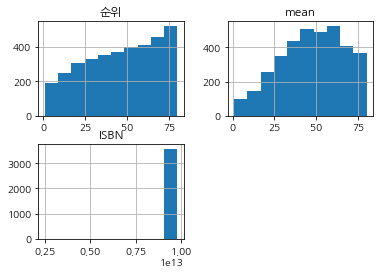

In [ ]:
df.hist();

In [ ]:
df.describe(include="O")

,상품명,저자,출판사,책소개,관리분류,설명,IMAGE,판매가
count,3581,3581,3581,3581,3581,3581,3581,3581
unique,3577,2979,951,3540,13,3534,3581,188
top,사람을 얻는 지혜,편집부 저,김영사,"드라마와 웹툰으로도 만들어진 레전드 웹소설 마침내, 종이책 출간! 2017년 2월부...",에세이,드라마 웹툰 레전드 웹소설 마침내 종이 화 연재 투데이 베스트 만큼 웹소설 재벌 막...,http://image.yes24.com/goods/105671479/XL,"14,400원"
freq,2,27,79,5,403,5,1,344


---

## LDA Topic Modeling (tomotopy api)

In [ ]:
pip install tomotopy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/chohj118/book_recommend/main/data/before_tomoto_final.csv')

In [ ]:
import tomotopy as tp
print(tp.isa)
import sys
import logging

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

avx2


In [ ]:
class TopicModeling :
    # 최소 5개 이상 설명에 등장하고
    # 전체 출현빈도는 15개 이상인 단어만 사용
    def __init__(self, df, k, min_df=8, min_cf=5) : 
        self.df = df
        self.k = k  # 토픽의 개수
        self.min_df = min_df
        self.min_cf = min_cf

    def LDA(self) :

        LDA_model = tp.LDAModel(k=self.k, min_df=self.min_df, min_cf=self.min_cf, tw=tp.TermWeight.ONE, rm_top=5, seed=42,
                                alpha=0.1, eta=0.01)
        for token in self.df['설명'].str.split(' '):
            LDA_model.add_doc(token)

        return LDA_model

    def train(self, LDA_model):
        LDA_model.train(0)
        print("Num docs :", len(LDA_model.docs), ', vocab_size:', LDA_model.num_vocabs, ', Num words:', LDA_model.num_words)
        print('Removed top word: ', LDA_model.removed_top_words)
        print('Training...', file=sys.stderr, flush=True) 
        for i in range(0, 1000, 100):
            LDA_model.train(100)
            print("Iteration : {}\tLog-likelihood: {}".format(i, LDA_model.ll_per_word))

    def result(self, LDA_model):
        for i in range(LDA_model.k):
            res = LDA_model.get_topic_words(i, top_n=3)
            print("Topic #{}".format(i), end='\t')
            print(', '.join(w for w, p in res))
    
    def get_coherence(self, LDA_model):
        coherence = tp.coherence
        score = coherence.Coherence(LDA_model).get_score()
        perplexity = LDA_model.perplexity
        print("topic 개수 : ", self.k, "| 사용된 vocab 수 : ", len(LDA_model.used_vocabs) , "| Coherence 점수 : ", score, 
                "| Perplexity 점수 : ", perplexity)
        return score, perplexity


In [ ]:
lda = TopicModeling(df, 32)
model = lda.LDA()
lda.train(model)
len(model.used_vocabs)
lda.result(model)
lda.get_coherence(model)

<ipython-input-227-4b1cce486b3c>:20: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  LDA_model.train(0)
Training...


Num docs : 3581 , vocab_size: 3457 , Num words: 152644
Removed top word:  ['사람', '세계', '삶', '역사', '여행']


<ipython-input-227-4b1cce486b3c>:25: RuntimeWarning: The training result may differ even with fixed seed if `workers` != 1.
  LDA_model.train(100)


Iteration : 0	Log-likelihood: -7.788100466924841
Iteration : 100	Log-likelihood: -7.715052969352913
Iteration : 200	Log-likelihood: -7.67163831179125
Iteration : 300	Log-likelihood: -7.648429776616983
Iteration : 400	Log-likelihood: -7.640406069953435
Iteration : 500	Log-likelihood: -7.6273473161361665
Iteration : 600	Log-likelihood: -7.628924346047703
Iteration : 700	Log-likelihood: -7.61972458636627
Iteration : 800	Log-likelihood: -7.6156087392471905
Iteration : 900	Log-likelihood: -7.612312309912333
Topic #0	설명, 활용, 이해
Topic #1	아이, 교육, 교사
Topic #2	사랑, 시인, 시
Topic #3	미국, 그녀, 뉴욕
Topic #4	길, 스님, 순례
Topic #5	정보, 여행지, 제주
Topic #6	경험, 시작, 이해
Topic #7	인류, 코로나, 위기
Topic #8	사회, 시대, 변화
Topic #9	음악, 클래식, 곡
Topic #10	아이, 놀이, 코
Topic #11	지능, 기술, 인공
Topic #12	디자인, 한글, 드로잉
Topic #13	소설, 작품, 문학
Topic #14	투자, 주식, 부동산
Topic #15	유튜브, 채널, 강의
Topic #16	하나님, 성경, 교회
Topic #17	마음, 사랑, 친구
Topic #18	정치, 대통령, 중국
Topic #19	철학, 인생, 이자
Topic #20	엄마, 아이, 그림책
Topic #21	부자, 돈, 경매
Topic #22	작품, 미술, 예술
Topic #23	사건, 

(-4.159049492313846, 2022.9503819708007)

In [ ]:
model.summary()

<Basic Info>
| LDAModel (current version: 0.12.3)
| 3581 docs, 152644 words
| Total Vocabs: 18922, Used Vocabs: 3457
| Entropy of words: 7.59489
| Entropy of term-weighted words: 7.59489
| Removed Vocabs: 사람 세계 삶 역사 여행
|
<Training Info>
| Iterations: 1000, Burn-in steps: 0
| Optimization Interval: 10
| Log-likelihood per word: -7.61231
|
<Initial Parameters>
| tw: TermWeight.ONE
| min_cf: 5 (minimum collection frequency of words)
| min_df: 8 (minimum document frequency of words)
| rm_top: 5 (the number of top words to be removed)
| k: 32 (the number of topics between 1 ~ 32767)
| alpha: [0.1] (hyperparameter of Dirichlet distribution for document-topic, given as a single `float` in case of symmetric prior and as a list with length `k` of `float` in case of asymmetric prior.)
| eta: 0.01 (hyperparameter of Dirichlet distribution for topic-word)
| seed: 42 (random seed)
| trained in version 0.12.3
|
<Parameters>
| alpha (Dirichlet prior on the per-document topic distributions)
|  [0.1079

In [ ]:
import itertools

In [ ]:
# 평가
for preset in ('u_mass', 'c_uci', 'c_npmi', 'c_v'):
    coh = tp.coherence.Coherence(model, coherence=preset)
    average_coherence = coh.get_score()
    coherence_per_topic = [coh.get_score(topic_id=k) for k in range(model.k)]
    print('==== Coherence : {} ===='.format(preset))
    print('평균:', average_coherence, '\n토픽 당 coherence:', coherence_per_topic)
    print()

==== Coherence : u_mass ====
평균: -4.159049492313846 
토픽 당 coherence: [-2.1804965270979486, -4.415414341371076, -9.152120224816553, -2.761400218242285, -13.738113228643659, -6.479064264240163, -2.5414136979637965, -2.1324154927747188, -2.740985246797747, -3.0209726324299164, -4.145987164681464, -2.7475650894835835, -7.596703075723454, -2.3703812062358063, -1.5002373521572843, -2.597541835409561, -1.589566009723777, -2.76431688246801, -2.2218221874303565, -2.768727486769596, -9.445453944315544, -2.4698703528265007, -4.351904101618037, -3.873912470245514, -4.152475165572257, -2.578128223154399, -2.3762746462502538, -4.82039581048564, -4.434733750444632, -2.4787835070904207, -3.64809356083175, -8.994314056747356]

==== Coherence : c_uci ====
평균: -0.8525040090127877 
토픽 당 coherence: [1.0045498744037586, 0.6495431033828521, -4.453056953135911, -2.1877406434611593, -5.975215496409739, -1.5335488865706768, 0.13128832922183756, 0.7104180924276282, 0.14423930151770417, 0.5297639531901931, -1.654

In [ ]:
df['top_topic'] = 0
df['topic_dist'] = 0
df['topic_words'] = 0

for i in tqdm(range(len(model.docs))):
    df["topic_dist"][i] = model.docs[i].get_topics(top_n=4)
    df['top_topic'][i] = model.docs[i].get_topics()[0][0]
    res = model.get_topic_words(df['top_topic'][i], top_n=5)
    df["topic_words"][i] = ' '.join(w for w, p in res)

df['topic_dict'] = 0
df['topic_dict'] = df["topic_dist"].apply(lambda x: dict(x))

  0%|          | 0/3581 [00:00<?, ?it/s]<ipython-input-232-0af2a940fc5d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["topic_dist"][i] = model.docs[i].get_topics(top_n=4)
/usr/local/lib/python3.8/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
<ipython-input-232-0af2a940fc5d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['top_topic']

In [ ]:
df

,Unnamed: 0,순위,mean,ISBN,상품명,저자,출판사,책소개,관리분류,설명,IMAGE,판매가,top_topic,topic_dist,topic_words,topic_dict
0,0,27.0,28.7,2510567147905,아직 끝이 아니다 (양장 한정판),김연경,가연,"꿈을 꾸는 것이 무엇이든 해야 하고, 할 수 있다 한국 여자배구 사상 최고의 왼쪽 ...",에세이,꿈 여자배구 사상 왼쪽 공격수 김연경 주목 유년 시절 일본 터키 진출 세계 인정 세...,http://image.yes24.com/goods/105671479/XL,"13,320원",3,"[(3, 0.32541388273239136), (17, 0.154544413089...",미국 그녀 뉴욕 올해 영국,"{3: 0.32541388273239136, 17: 0.154544413089752..."
1,1,59.0,59.0,2511464896507,만화로 보는 3분 철학 세트,서정욱/김재훈,카시오페아,지금까지 이런 철학 만화는 없었다! 철학의 기초 개념을 잡는 가장 쉬운 책! 만화로...,인문,철학 만화 철학 기초 개념 만화 개념 서양 철학사 철학 현대 철학 세트 인문학 철학...,http://image.yes24.com/goods/114648965/XL,"44,640원",19,"[(19, 0.42398589849472046), (27, 0.32637166976...",철학 인생 이자 인간 시대,"{19: 0.42398589849472046, 27: 0.32637166976928..."
2,2,16.0,44.2,9782067255425,미쉐린 가이드 서울 2022,미쉐린 트래블 파트너,미쉐린코리아,"세계 최고 권위의 레스토랑 및 호텔 평가서이자, 전세계 미식가들의 바이블인 ‘미쉐린...",건강 취미,세계 권위 레스토랑 호텔 평가 이자 전세계 미식 바이블 미쉐린 가이드 미슐랭 가이드...,https://shopping-phinf.pstatic.net/main_324687...,"19,800원",28,"[(28, 0.44224563241004944), (5, 0.131611287593...",도시 일본 문화 서울 음식,"{28: 0.44224563241004944, 5: 0.131611287593841..."
3,3,51.0,39.1,9788901033518,돼지책,앤서니 브라운/허은미,웅진주니어,"그림책의 거장, 앤서니 브라운의 대표작 『돼지책』 국내 출간 20주년 기념 리커버 ...",유아,그림책 거장 앤서니 브라운 돼지 주년 기념 리 커버 한정판 메시지 표현 그림책 고전...,https://shopping-phinf.pstatic.net/main_324446...,"9,900원",22,"[(22, 0.45047077536582947), (8, 0.154642835259...",작품 미술 예술 시리즈 사랑,"{22: 0.45047077536582947, 8: 0.154642835259437..."
4,4,79.0,79.0,9788901047904,우리 엄마,허은미/앤서니 브라운,웅진주니어,인기 그림책 작가 앤서니 브라운의 신작. 아이에게 세상에서 가장 놀랍고 뛰어난 존재...,유아,인기 그림책 앤서니 브라운 신작 아이 존재 엄마 모습 만능 재주 사랑 엄마 가족 엄...,https://shopping-phinf.pstatic.net/main_324416...,"11,700원",20,"[(20, 0.5229764580726624), (17, 0.327250450849...",엄마 아이 그림책 달 가족,"{20: 0.5229764580726624, 17: 0.327250450849533..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3576,3576,48.0,41.5,9791197980701,자소서 바이블 2.0,면접왕 이형,얼라이브북스(alivebooks),독보적 취업 유튜버 ‘면접왕 이형’의 베스트셀러 ‘자소서 바이블’이 개정판으로 돌아...,IT 모바일,독보 취업 유튜버 면접 이형 자소 바이블 최종 합격 연결 자소 성법 지원 동기 방법...,https://shopping-phinf.pstatic.net/main_341160...,"17,820원",0,"[(0, 0.30218029022216797), (21, 0.151242062449...",설명 활용 이해 입문 내용,"{0: 0.30218029022216797, 21: 0.151242062449455..."
3577,3577,29.0,29.0,9791198013002,웹 3.0 넥스트 이코노미,김미경/에리카 강/권헌영/김승주/신동형/윤준탁 /이승환/이신혜/정지훈,어웨이크북스,"치솟는 물가, 끝없는 금리 인상, 폭등하는 환율… 길이 보이지 않는 극심한 불황의 ...",경제 경영,물가 금리 인상 폭등 환율 길이 보이지 불황 시대 돈 기회 잡 전문가 인 출동 불황...,https://shopping-phinf.pstatic.net/main_359119...,"16,200원",14,"[(14, 0.2797422409057617), (29, 0.225823700428...",투자 주식 부동산 시장 투자자,"{14: 0.2797422409057617, 29: 0.225823700428009..."
3578,3578,30.0,45.0,9791198029294,부동산 하락장에서 살아남기,대치동 키즈,재유,"""무주택자부터 다주택자까지, 금융 위기 하락장을 먼저 겪은 15년 차 투자자가 건네...",경제 경영,주택 주택 금융 위기 하락 먼저 차 투자자 맞춤 답안 차 투자자 대치동 키즈 과거 ...,https://shopping-phinf.pstatic.net/main_351742...,"15,300원",14,"[(14, 0.42224588990211487), (6, 0.121810711920...",투자 주식 부동산 시장 투자자,"{14: 0.42224588990211487, 6: 0.121810711920261..."
3579,3579,13.0,12.5,9791198042804,무뎌진 감정이 말을 걸어올 때,김소영,책발전소X테라코타,"MBC 아나운서를 그만둔 후 ‘당인리책발전소’ 서점 주인으로, 그리고 방송인으로 활...",에세이,아나운서 당인 리책 발전소 서점 주인 방송인 활동 인생 방향 김소영 힘 곁 준 덕분...,https://shopping-phinf.pstatic.net/main_354628...,"14,220원",17,"[(17, 0.2637506127357483), (29, 0.236824125051...",마음 사랑 친구 모습 시작,"{17: 0.2637506127357483, 29: 0.236824125051498..."


### 데이터 다운로드

In [ ]:
df.to_csv('https://raw.githubusercontent.com/chohj118/book_recommend/main/data/after_tomoto_final.csv', encoding="utf-8-sig")

## 추천 시스템

In [ ]:
import pandas as pd
import numpy as np
from ast import literal_eval
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/chohj118/book_recommend/main/data/after_tomoto_final.csv', index_col=0)
print(df.shape)
display(df.head(2))

(3581, 16)


,Unnamed: 0.1,순위,mean,ISBN,상품명,저자,출판사,책소개,관리분류,설명,IMAGE,판매가,top_topic,topic_dist,topic_words,topic_dict
0,0,27.0,28.7,2510567147905,아직 끝이 아니다 (양장 한정판),김연경,가연,"꿈을 꾸는 것이 무엇이든 해야 하고, 할 수 있다 한국 여자배구 사상 최고의 왼쪽 ...",에세이,꿈 여자배구 사상 왼쪽 공격수 김연경 주목 유년 시절 일본 터키 진출 세계 인정 세...,http://image.yes24.com/goods/105671479/XL,"13,320원",3,"[(3, 0.32541388273239136), (17, 0.154544413089...",미국 그녀 뉴욕 올해 영국,"{3: 0.32541388273239136, 17: 0.154544413089752..."
1,1,59.0,59.0,2511464896507,만화로 보는 3분 철학 세트,서정욱/김재훈,카시오페아,지금까지 이런 철학 만화는 없었다! 철학의 기초 개념을 잡는 가장 쉬운 책! 만화로...,인문,철학 만화 철학 기초 개념 만화 개념 서양 철학사 철학 현대 철학 세트 인문학 철학...,http://image.yes24.com/goods/114648965/XL,"44,640원",19,"[(19, 0.42398589849472046), (27, 0.32637166976...",철학 인생 이자 인간 시대,"{19: 0.42398589849472046, 27: 0.32637166976928..."


In [ ]:
df['topic_dict'] = df['topic_dict'].apply(lambda x: eval(x))
df_topic = pd.DataFrame(df['topic_dict'].tolist(), index=df.index).fillna(0)
pearson_sim = np.corrcoef(df_topic.to_numpy())

### Topic Recommend

In [ ]:
def select_topic(topic):
    topic_index = df[df['topic_words']==(topic)].index
    return topic_index.sort_values(ascending=True).tolist()

def recommand(book):
    book_index = topic_df[topic_df['상품명'] == book].index[0]
    df_pearson = pd.DataFrame(pearson_sim, index=df.index, columns=df.index)
    sim = df_pearson[book_index].sort_values(ascending=False)
    df_sim = df.loc[sim.index, ["상품명", "설명",'관리분류', 'topic_words','IMAGE','판매가']].join(sim)
    return df_sim.head(11)

### Search Book

In [ ]:
def select_topic(topic):
    topic_index = df[df['top_topic']==(topic)].index
    return topic_index.tolist()
def search_book(title):
    title = re.sub(r"\s", "", title)
    title_1 = df['상품명'].apply(lambda x: re.sub(r"\s", "", x))
    book_title = df.loc[title_1.str.contains(title), "상품명"].tolist()
    return book_title
def choice_book(search):
    book_title = df.loc[df['상품명'] == search, ['상품명', '설명', '관리분류', 'IMAGE', '판매가']]
    return book_title
def recommand(book):
    book_index = df[df['상품명'] == book].index[0]
    df_pearson = pd.DataFrame(pearson_sim, index=df.index, columns=df.index)
    sim = df_pearson[book_index].sort_values(ascending=False)
    df_sim = df.loc[sim.index, ["상품명", "설명",'관리분류', 'topic_words','IMAGE','판매가']].join(sim)
    return df_sim.head(11)